In [6]:
import proplot as plot
import torch
import numpy as np
import matplotlib.pylab as pl
import sklearn
from sklearn import datasets
import ot
plot.rc['figure.facecolor'] = "white"

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
torch.CUDA_LAUNCH_BLOCKING=1

print('Used device: '+device)

Used device: cpu


In [8]:
get_rot= lambda theta : np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
def make_blobs_reg(n_samples, n_blobs, scale=.5):
    per_blob=int(n_samples/n_blobs)
    result = np.random.randn(per_blob,2) * scale + 5
    theta=(2*np.pi)/(n_blobs)
    for r in range(1,n_blobs):
        new_blob=(np.random.randn(per_blob,2) * scale + 5).dot(get_rot(theta*r))
        result = np.vstack((result,new_blob))
    return result

# random MoG
def make_blobs_random(n_samples, n_blobs, scale=.5, offset=3):
    per_blob=int(n_samples/n_blobs)
    result = np.random.randn(per_blob,2) * scale + np.random.randn(1,2)*offset
    for r in range(1,n_blobs):
        new_blob=np.random.randn(per_blob,2) * scale + np.random.randn(1,2)*offset
        result = np.vstack((result,new_blob))
    return result

#%%
def make_spiral(n_samples, noise=.5):
    n = np.sqrt(np.random.rand(n_samples,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_samples,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_samples,1) * noise
    return np.array(np.hstack((d1x,d1y)))

In [9]:
def compute_bary_line(X_line_sort,Y_line_sort,q) :

    Z_line_sort=(X_line_sort+Y_line_sort)/2
    Z = Z_line_sort[:,None]*q[None,:]
    
    return Z_line_sort,Z

def W2_line_W(X,X_line,X_line_sort,Y_line_sort,q): # X distrib and Y on the line q
    
    n=X.shape[0]
        
    X_proj = X_line[:,None]*q[None,:]
    
    W_s = torch.norm(X-X_proj)**2
    
    W_1d = torch.sum((X_line_sort-Y_line_sort)**2)
    
    return W_s/n+W_1d/n

def compute_bary_gene(X_sort,Y_sort,t=.5):
    
    bary=(1-t)*X_sort+t*Y_sort

    return bary

def upperW2(X,Y,q,t=.5):
    n=X.shape[0]
    
    X_line=torch.matmul(X,q)
    Y_line=torch.matmul(Y,q)
    
    X_line_sort,u=torch.sort(X_line,axis=0)
    Y_line_sort,v=torch.sort(Y_line,axis=0)
    
    X_sort=X[u]
    Y_sort=Y[v]
    
    Z_line_sort,Z=compute_bary_line(X_line_sort,Y_line_sort,q)
    
    bary=compute_bary_gene(X_sort,Y_sort,t)
    bary_line=torch.matmul(bary,q)
    bary_line_sort,_=torch.sort(bary_line,axis=0)
        
    W_baryZ=W2_line_W(bary,bary_line,bary_line_sort,Z_line_sort,q)
    W_XZ=W2_line_W(X,X_line,X_line_sort,Z_line_sort,q)
    W_YZ=W2_line_W(Y,Y_line,Y_line_sort,Z_line_sort,q)

    
    return (-1/(t*(1-t)))*W_baryZ+(1/(1-t))*W_YZ+(1/t)*W_XZ

In [12]:
def maxSW2(xs,xt,proj): #add a seed?
    
    xs_line=torch.matmul(xs.float(),proj[:,None].float())
    xt_line=torch.matmul(xt.float(),proj[:,None].float())
    
    xs_line_sorted,_=torch.sort(xs_line,axis=0)
    xt_line_sorted,_=torch.sort(xt_line,axis=0)
    W_1d = torch.sum((xs_line_sorted-xt_line_sorted)**2)
    
    return W_1d

In [8]:
def get_maxSW(Xa,Xb,lr=1e-2,num_iter=100):
    init=torch.ones(Xa.shape[1],requires_grad=True, device=Xa.device, dtype=Xa.dtype)
    theta=init
    #theta = torch.tensor([init], requires_grad=True, device=Xa.device, dtype=Xa.dtype)
    optimizer = torch.optim.Adam([theta], lr=lr)
    loss_l=[]
    proj = theta/torch.norm(theta)
    for i in range(num_iter):
        # build projector
        loss = -maxSW2(Xa.float(),Xb.float(),proj.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_l.append(-loss.data)
        proj = theta/torch.norm(theta)
    return theta, loss_l

In [14]:
def make_data(expe,n_samples,dim=2):
    if expe=='spirals':
        r=2.5
        xs = make_spiral(n_samples=n_samples, noise=1)
        xt = make_spiral(n_samples=n_samples, noise=1).dot(get_rot(r))
    elif expe=='mog_reg':
        r=.5
        xs = make_blobs_reg(n_samples=n_samples, n_blobs=3)
        xt = make_blobs_reg(n_samples=n_samples, n_blobs=3).dot(get_rot(r))
    elif expe=='mog_random':
        xs = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=10)
        xt = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=10)
    elif expe=='custom':
        xs = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=1,offset=0)-6
        xt = make_spiral(n_samples=n_samples, noise=1)
    elif expe=='two_moons':
        X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.05)
        xs = X[y==0,:]
        xt = X[y==1,:]
    elif expe=='gaussians' :
        mu_s = np.random.randint(-10,10,dim)
        #mu_s = np.random.randint(-1,1,dim)
        mu_s=np.array([-10,0])
        cov_s = np.diag(np.random.randint(1,5,dim))
        cov_s=np.array([1,10])
        cov_s = cov_s * np.eye(dim)
        #cov_s=np.array([[1,0],[0,10]])
        mu_t = np.random.randint(-10,10,dim)
        mu_t=np.array([10,0])
        #mu_t = np.random.randint(-1,1,dim)
        #mu_t=np.array([50,50])
        cov_t = np.diag(np.random.randint(1,5,dim))
        cov_t=np.array([1,1])
        cov_t = cov_t * np.eye(dim)
        #cov_t=np.array([[1,0],[0,10]])
        xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
        xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
    return xs,xt



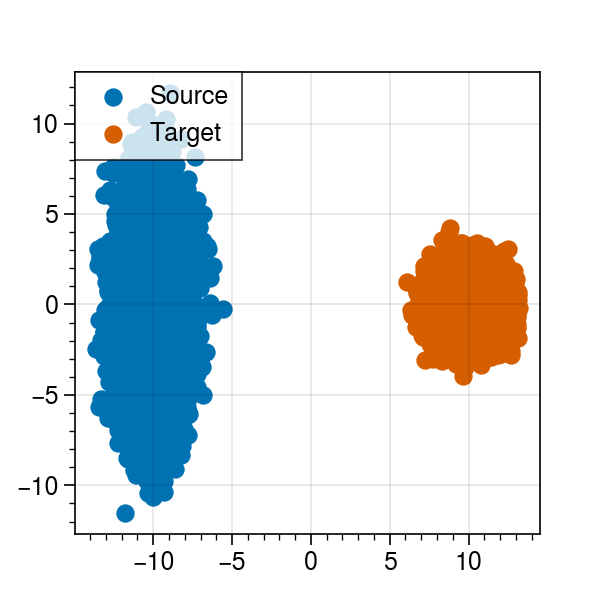

In [15]:
n_samples=10000
xs,xt=make_data('gaussians',n_samples,dim=2)

dim=xs.shape[1]
ns=np.shape(xs)[0]
nt=np.shape(xt)[0]
a, b = np.ones((ns,)), np.ones((nt,))
pl.figure(figsize=(3,3))
pl.scatter(xs[:, 0], xs[:, 1], c='C0', label='Source')
pl.scatter(xt[:, 0], xt[:, 1], c='C1', label='Target')
pl.legend(loc=2)

Xs_torch = torch.from_numpy(xs).to(device)
Xt_torch = torch.from_numpy(xt).to(device)

In [16]:
Xs_torch = torch.from_numpy(xs).to(device)
Xt_torch = torch.from_numpy(xt).to(device)

upperW2(Xs_torch.float(),Xt_torch.float(),torch.tensor([0.7071, 0.7071]),t=.5)

tensor(407.6313)

In [20]:
def compute_bary_line_proj(X_line_sort,Y_line_sort,theta) :

    Z_line_sort=(X_line_sort+Y_line_sort)/2
    Z = Z_line_sort[:,None]*theta[None,:]
    
    return Z_line_sort,Z

def W2_line_W_proj(X,X_line,X_line_sort,Y_line_sort,theta): # X distrib and Y on the line q
    
    n=X.shape[0]
    
    X_proj = X_line[:,None,:]*theta[None,:,:]
    if len(X.shape)==2:
        W_s = torch.norm(X[:,:,None]-X_proj,dim=(0,1))**2
    else :
        W_s = torch.norm(X-X_proj,dim=(0,1))**2
        
    W_1d = torch.sum((X_line_sort-Y_line_sort)**2,axis=0)

    return W_s/n+W_1d/n


def compute_bary_gene_proj(X_sort,Y_sort):
    
    bary=(X_sort+Y_sort)/2

    return bary

def upperW2_proj(X,Y,theta):
    n=X.shape[0]

    X_line=torch.matmul(X,theta)
    Y_line=torch.matmul(Y,theta)

    X_line_sort,u=torch.sort(X_line,axis=0)
    Y_line_sort,v=torch.sort(Y_line,axis=0)
   

    X_sort=X[u].transpose(1,2)
    Y_sort=Y[v].transpose(1,2)

    Z_line_sort,Z=compute_bary_line_proj(X_line_sort,Y_line_sort,theta)
    
    bary=compute_bary_gene_proj(X_sort,Y_sort)
    bary_line=torch.zeros((n,n_proj))
    for s in range(n_proj):
        bary_line[:,s]=torch.matmul(bary[:,:,s],theta[:,s])
    bary_line_sort,_=torch.sort(bary_line,axis=0)
    bary_line_sort,_=torch.sort(bary_line,axis=0)
        
    W_baryZ=W2_line_W_proj(bary,bary_line,bary_line_sort,Z_line_sort,theta)
    W_XZ=W2_line_W_proj(X,X_line,X_line_sort,Z_line_sort,theta)
    W_YZ=W2_line_W_proj(Y,Y_line,Y_line_sort,Z_line_sort,theta)
    
    return 2*W_YZ+2*W_XZ-4*W_baryZ,theta

### MAX ###
def maxSW_proj(X,Y,proj): 

    X_line=torch.matmul(X.float(),proj.float())
    Y_line=torch.matmul(Y.float(),proj.float())

    X_line_sorted,_=torch.sort(X_line,axis=0)
    Y_line_sorted,_=torch.sort(Y_line,axis=0)

    W_1d = torch.sum((X_line_sorted-Y_line_sorted)**2,axis=0)
    return W_1d.data,proj

In [43]:
n_proj=5000
proj = np.random.randn(dim, n_proj)
proj = torch.tensor(proj / np.sqrt(np.sum(proj**2, 0, keepdims=True)))

loss_min,proj_min=upperW2_proj(Xs_torch,Xt_torch,proj)
loss_max,proj_max=maxSW_proj(Xs_torch,Xt_torch,proj)

loss_min,order_min=torch.sort(loss_min,descending=True)
loss_max,order_max=torch.sort(loss_max,descending=False)

In [44]:
bestproj_min=proj_min[:,order_min[-1]]
bestproj_max=proj_max[:,order_max[-1]]

Text(0.5, 1.0, 'SWGG')

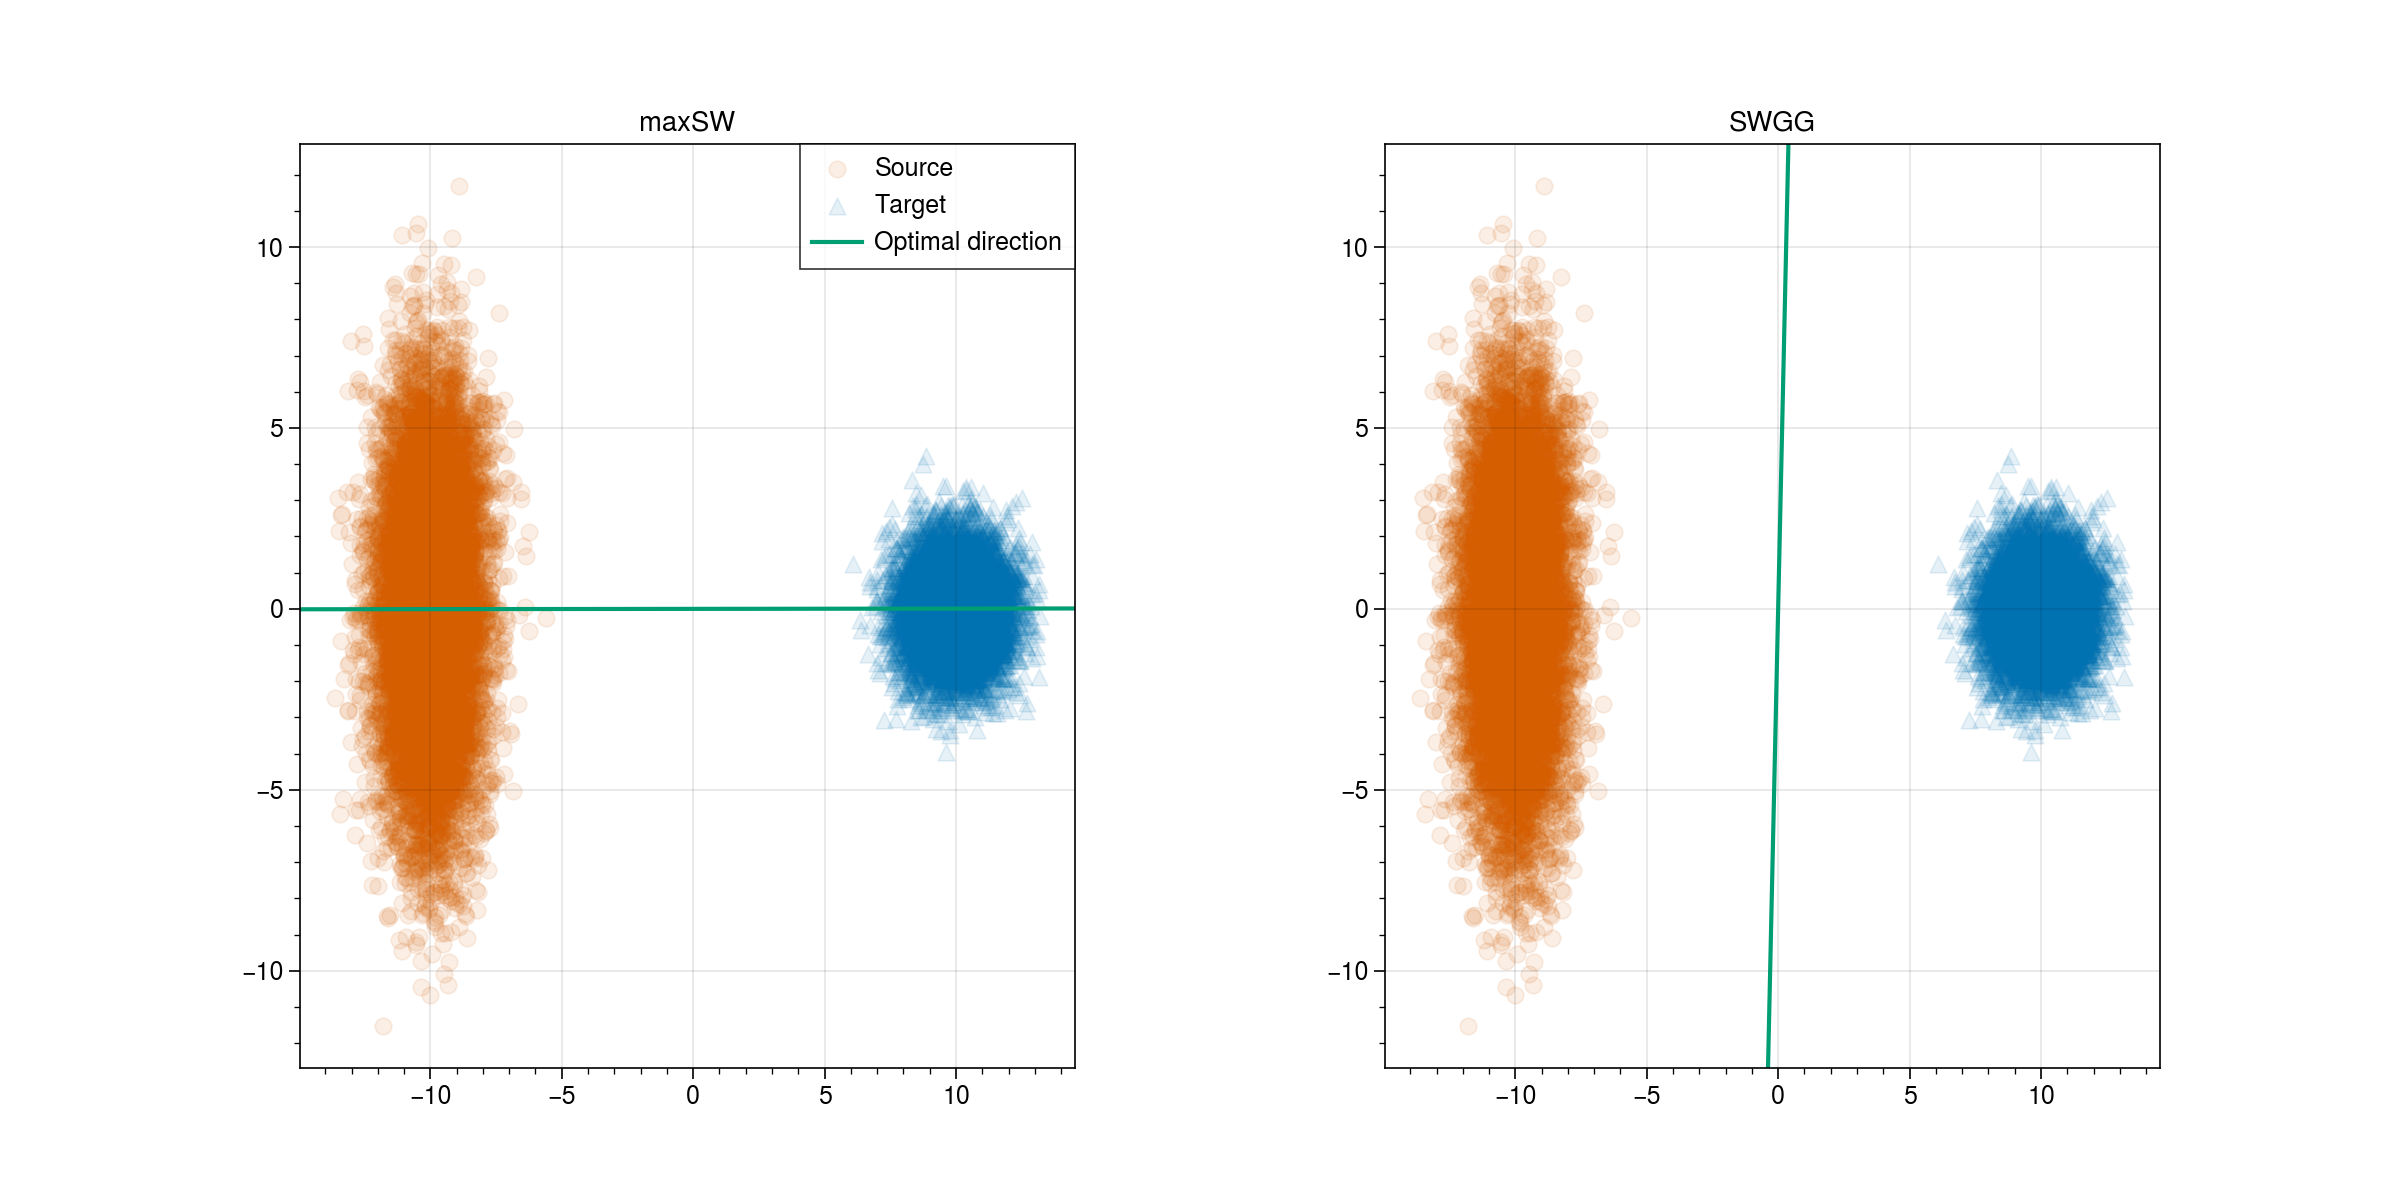

In [45]:
### minSW ###

pl.figure(figsize=(12,6))
grid = pl.GridSpec(1, 2, wspace=0.4, hspace=0.3)

Xs_proj=torch.matmul(Xs_torch.float(),bestproj_max[:,None].float())
Xs_proj=Xs_proj*bestproj_max
Xt_proj=torch.matmul(Xt_torch.float(),bestproj_max[:,None].float())
Xt_proj=Xt_proj*bestproj_max

pl.subplot(grid[0, 0])
pl.scatter(Xs_torch[:, 0], Xs_torch[:, 1], c='C1', label='Source',alpha=0.1)
#pl.scatter(Xs_proj[:, 0], Xs_proj[:, 1], c='C0', label='Source projected',alpha=.5)
pl.scatter(Xt_torch[:, 0], Xt_torch[:, 1], c='C0', label='Target',alpha=0.1,marker="^")
#pl.scatter(Xt_proj[:, 0], Xt_proj[:, 1], c='C1', label='Target projected',alpha=.5)
pl.axline((0,0), [bestproj_max[0],bestproj_max[1]], color='C2',label='Optimal direction')
pl.title('maxSW')
pl.legend()


Xs_proj=torch.matmul(Xs_torch.float(),bestproj_min[:,None].float())
Xs_proj=Xs_proj*bestproj_min

Xt_proj=torch.matmul(Xt_torch.float(),bestproj_min[:,None].float())
Xt_proj=Xt_proj*bestproj_min




pl.subplot(grid[0, 1])
pl.scatter(Xs_torch[:, 0], Xs_torch[:, 1], c='C1', label='Source',alpha=0.1)
#pl.scatter(Xs_proj[:, 0], Xs_proj[:, 1], c='C0', label='Source projected',alpha=.5)
pl.scatter(Xt_torch[:, 0], Xt_torch[:, 1], c='C0', label='Target',alpha=0.1,marker="^")
#pl.scatter(Xt_proj[:, 0], Xt_proj[:, 1], c='C1', label='Target projected',alpha=.5)
pl.axline((0,0), [bestproj_min[0],bestproj_min [1]], color='C2')
pl.title('SWGG')

